In [1]:
import numpy as np
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit import IBMQ,Aer,transpile,assemble
from qiskit.visualization import plot_histogram,plot_bloch_multivector,array_to_latex
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state
IBMQ.save_account('eb264c4a6d39359629fc0dd4d0031812fb511701c624409f3dd905af17e33f3d6d792b9b0b449b1931f1acdb2578aee7cde105c736e48c735e20603a378299c8')
provider = IBMQ.load_account()

C:\Users\Kesha\AppData\Local\Temp\ipykernel_7456\1341610380.py:7: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account('eb264c4a6d39359629fc0dd4d0031812fb511701c624409f3dd905af17e33f3d6d792b9b0b449b1931f1acdb2578aee7cde105c736e48c735e20603a378299c8')
C:\Users\Kesha\AppData\Local\Temp\ipykernel_7456\1341610380.py:7: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'

In [2]:
qr=QuantumRegister(3,name="q")
crz=ClassicalRegister(1,name="crz")
crx=ClassicalRegister(1,name="crx")
teleportation_circuit=QuantumCircuit(qr,crz,crx)


In [3]:
def entanglement(qc,a,b):
    qc.h(a)
    qc.cx(a,b)

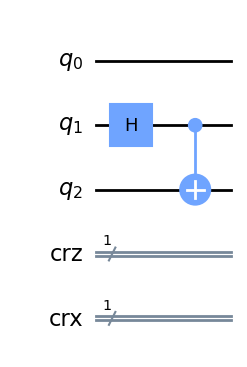

In [4]:
entanglement(teleportation_circuit,1,2)
teleportation_circuit.draw(output='mpl')

In [5]:
def alice_gates(qc,psi,a):
    qc.cx(psi,a)
    qc.h(psi)

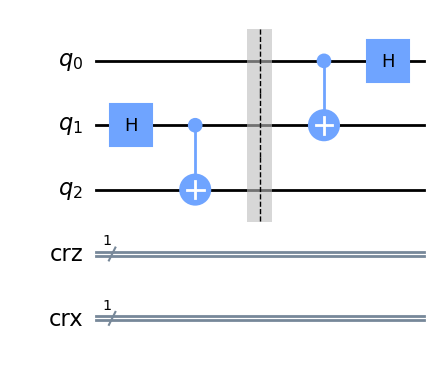

In [6]:
teleportation_circuit.barrier()
alice_gates(teleportation_circuit,0,1)
teleportation_circuit.draw(output='mpl')

In [7]:
def measure_set(qc,psi,a,crz,crx):
    qc.barrier()
    qc.measure(psi,crz)
    qc.measure(a,crx)

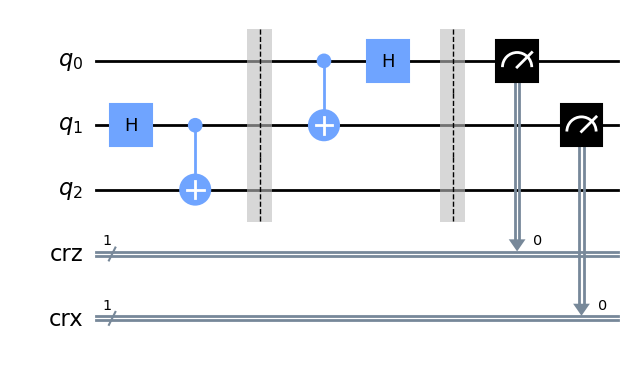

In [8]:
measure_set(teleportation_circuit,0,1,0,1)
teleportation_circuit.draw(output='mpl')

In [9]:
def bob_gates(qc,b,crz,crx):
    qc.x(b).c_if(crx,1)
    qc.z(b).c_if(crz,1)

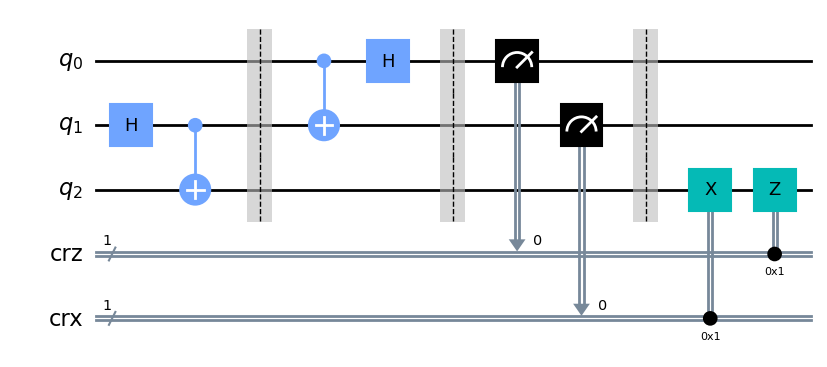

In [10]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit,2,crz,crx)
teleportation_circuit.draw(output='mpl')

<IPython.core.display.Latex object>

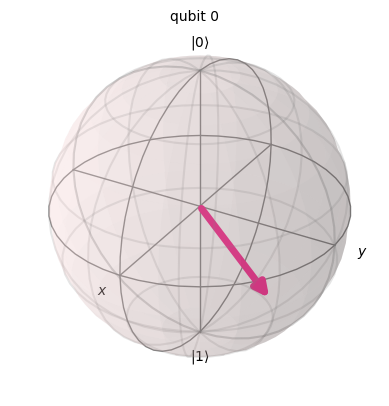

In [11]:
psi=random_state(1)
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

In [12]:
init_gate=Initialize(psi)
init_gate.label='init'

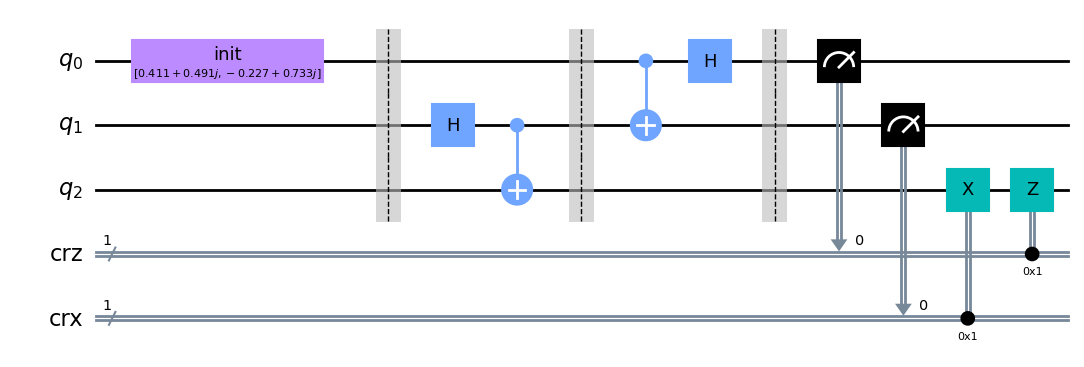

In [13]:
qr=QuantumRegister(3,name='q')
crz=ClassicalRegister(1,name='crz')
crx=ClassicalRegister(1,name='crx')
qc=QuantumCircuit(qr,crz,crx)

qc.append(init_gate,[0])
qc.barrier()


entanglement(qc,1,2)
qc.barrier()

alice_gates(qc,0,1)

measure_set(qc,0,1,0,1)

bob_gates(qc,2,crz,crx)

qc.draw(output='mpl')


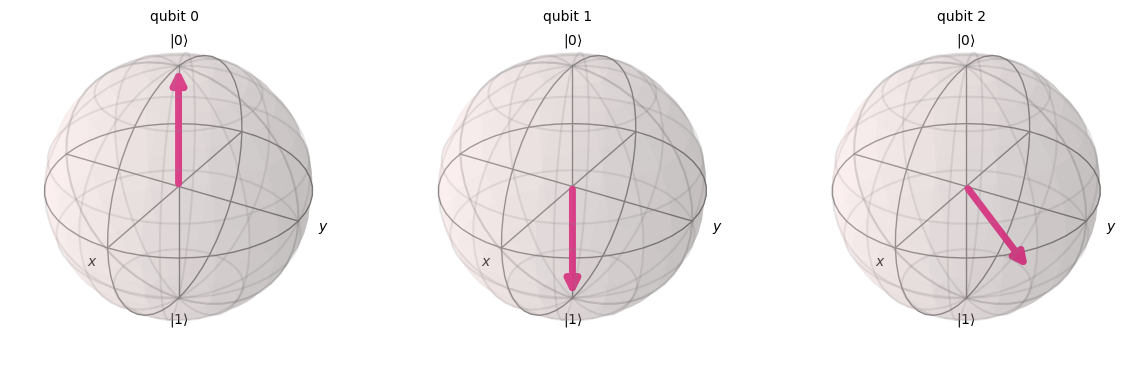

In [14]:
sim=Aer.get_backend('statevector_simulator')
# sim.save_statevector()
out_vector=sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

In [15]:
inverse_init_gate=init_gate.gates_to_uncompute()

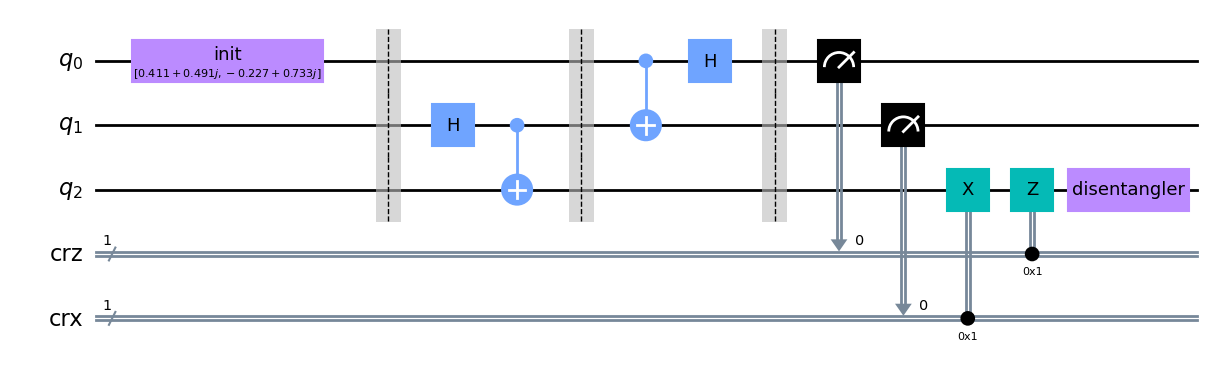

In [16]:
qr=QuantumRegister(3,name='q')
crz=ClassicalRegister(1,name='crz')
crx=ClassicalRegister(1,name='crx')
qc=QuantumCircuit(qr,crz,crx)

qc.append(init_gate,[0])
qc.barrier()


entanglement(qc,1,2)
qc.barrier()

alice_gates(qc,0,1)

measure_set(qc,0,1,0,1)

bob_gates(qc,2,crz,crx)

qc.append(inverse_init_gate,[2])

qc.draw(output='mpl')


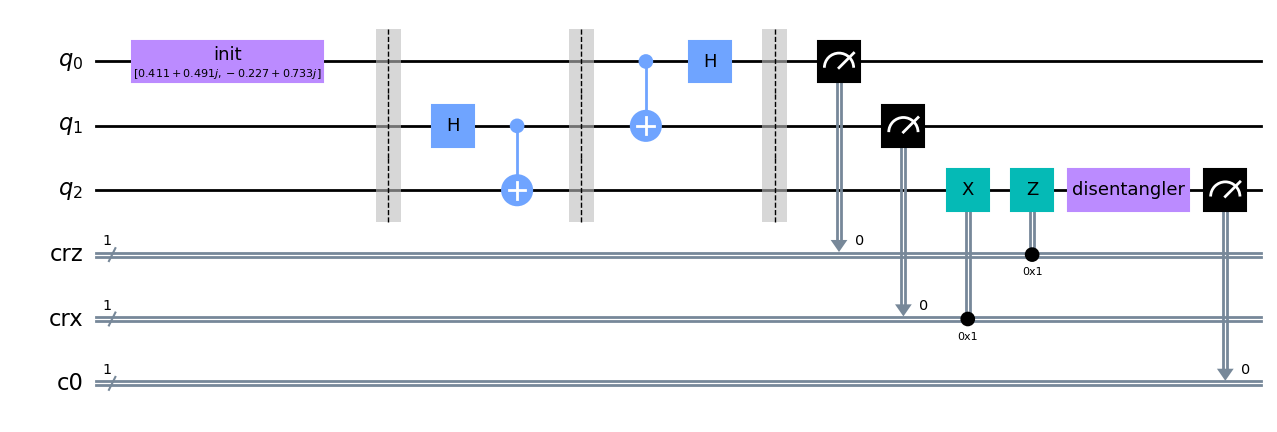

In [17]:
cr_result=ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')


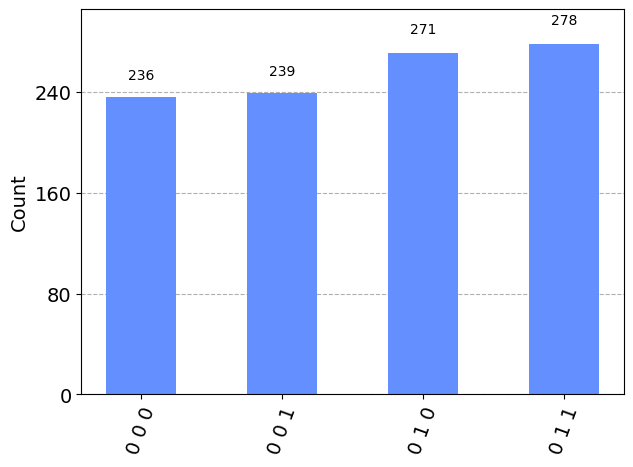

In [18]:
sim=Aer.get_backend('qasm_simulator')
t_qc=transpile(qc,sim)
counts=sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [19]:
def new_bob_gates(qc,psi,a,b):
    qc.cx(a,b)
    qc.cz(psi,b)

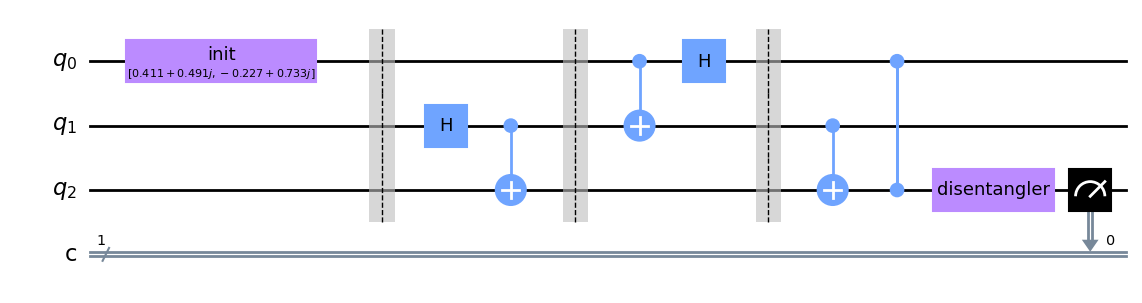

In [20]:
qr=QuantumRegister(3,name='q')
qc=ClassicalRegister(1,name='c')
# crz=ClassicalRegister(1,name='crz')
# crx=ClassicalRegister(1,name='crx')
# qc=QuantumCircuit(qr,crz,crx)
qc=QuantumCircuit(qr,qc)
qc.append(init_gate,[0])
qc.barrier()


entanglement(qc,1,2)
qc.barrier()

alice_gates(qc,0,1)

qc.barrier()

# measure_set(qc,0,1,0,1)

new_bob_gates(qc,0,1,2)

qc.append(inverse_init_gate,[2])

qc.measure(2,0)

qc.draw(output='mpl')


In [21]:
provider=IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend=least_busy(provider.backends(filters= lambda b: b.configuration().n_qubits>=3 and not b.configuration().simulator and b.status().operational==True))
t_qc=transpile(qc,backend,optimization_level=3)
job=backend.run(t_qc)
job_monitor(job)

Job Status: job has successfully run


{'0': 3527, '1': 473}


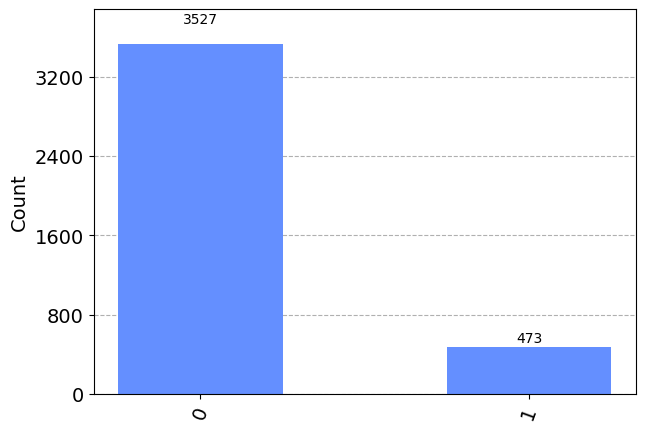

In [22]:
exp_result=job.result()
exp_counts=exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [23]:
print(f"The experimental error rate: {exp_counts['1']/sum(exp_counts.values())*100:.3f}%")

The experimental error rate: 11.825%
